In [20]:
# import
from hsflfm.config import home_directory
from hsflfm.util import (
    load_graph_images,
    load_dictionary,
    generate_A_matrix,
    MetadataManager,
)
from hsflfm.calibration import (
    CalibrationInfoManager,
    SystemVertexParser,
    SystemCalibrator,
    FLF_System
)

from hsflfm.calibration.vertices_organizing_functions import (
    organize_by_axis, ##My Import
    get_average_spacing,
    find_irregular_points
)
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle


import matplotlib

Step 1: Parse Vertices

In [36]:
# calibration filename can be manually specified or pulled from stored metadata
# the specified specimen can be any specimen that was filmed on the under these calibration conditions
#specimen = "20250212_OB_1"
specimen = "20240506_OB_6"

mm = MetadataManager(specimen)

#calibration_filename = mm.calibration_filename


calibration_folder = mm.calibration_folder
calibration_filename = mm.calibration_filename

#calibration_filename = r"C:/Users/abhin/Documents/Graduate School/Patek Research Docs/test_calibration.json"

print(calibration_filename)

info_manager = CalibrationInfoManager(calibration_filename)
print(calibration_folder)


C:/Users/abhin/OneDrive - Duke University/Melody W Young's files - Odontomachus brunneus/Abhinav_test_data/20240506/calibration_images/calibration_information
C:/Users/abhin/OneDrive - Duke University/Melody W Young's files - Odontomachus brunneus/Abhinav_test_data/20240506/calibration_images


In [37]:
# known information
info_manager.vertex_spacing_m = 500e-6  # spacing between vertices on the graph target
info_manager.pixel_size = 52e-6  # pixel size in meters of the camera

info_manager.save_all_info()

In [38]:
# give the manager enough information to find the graph images
# this may need to be changed if different naming conventions were used
# the dictionary just needs to contain a substring that is unique to the specific plane image

plane_names = np.sort([i for i in os.listdir(calibration_folder) if "tiff" in i])
name_dict = {}
for i, name in enumerate(plane_names):
    name_dict[i] = name
info_manager.plane_names = name_dict

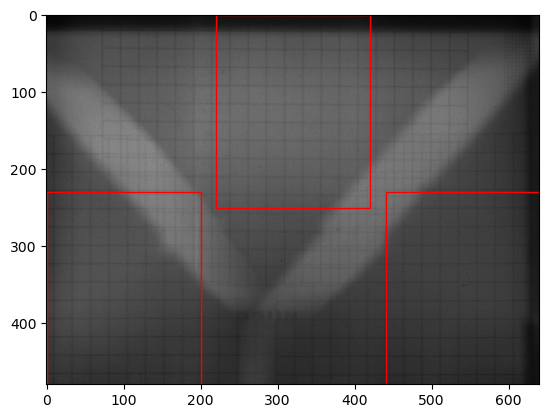

In [39]:
# load one image to identify where images should be cropped
# Right now, crops are expected to be the same size for all views

#standard crops for 3 camera system
crop_indices = {
    0: [230, 480, 0, 200],
    1: [230, 480, 440, 640],
    2: [0, 250, 220, 420],
}

# standard crops for 6 camera system
# crop_indices = {
#     0: [20, 250, 0, 210],
#     1: [250, 480, 0, 210],
#     2: [20, 250, 220, 430],
#     3: [250, 480, 220, 430],
#     4: [20, 250, 430, 640],
#     5: [250, 480, 430, 640]
# }

# crop_indices = {
#     0: [10, 240,10, 220],
#     1: [240, 470, 0, 210],
#     2: [10, 240, 240, 450],
#     3: [240, 470, 220, 430],
#     4: [10, 240, 460, 640],
#     5: [240, 470, 430, 640]
# }

# this could be done with any image, including of an ant
image_filename = calibration_folder + "/" + plane_names[0]
raw_image = Image.open(image_filename)
plt.imshow(raw_image)
ax = plt.gca()
for c in crop_indices.values():
    rect = Rectangle((c[2], c[0]), c[3] - c[2], c[1] - c[0], fill=False, color="red")
    ax.add_artist(rect)

In [40]:
info_manager.crop_indices = crop_indices
info_manager.save_all_info()

In [41]:
# load all the images
all_images = load_graph_images(
    folder=calibration_folder, calibration_filename=calibration_filename
)

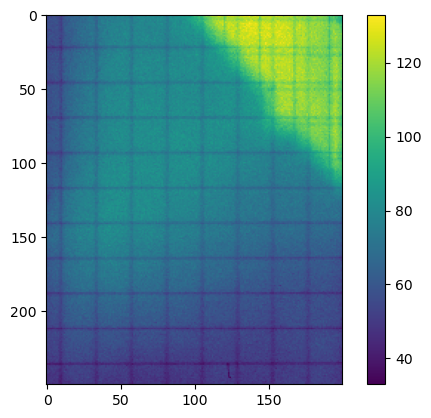

In [42]:
# view one image to get the expected spacing between lines
plt.figure()
plt.imshow(all_images[0][0])
plt.colorbar()

In [43]:
expected_spacing = 160 - 135

In [44]:
parser = SystemVertexParser(
    calibration_filename,
    expected_vertex_spacing=expected_spacing,
    all_images=all_images,
)

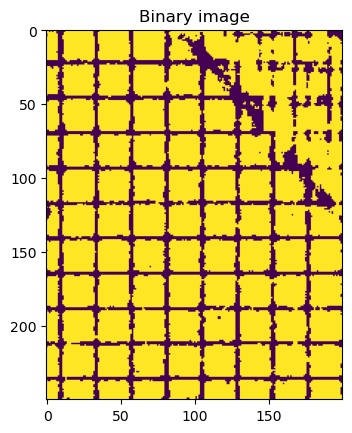

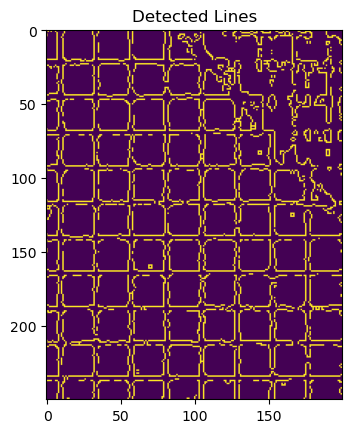

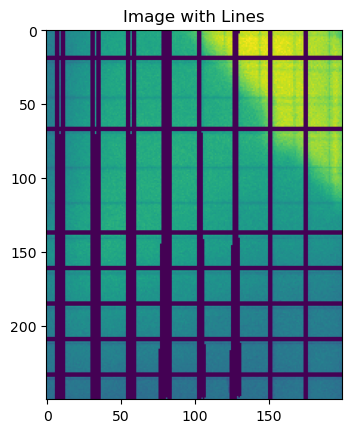

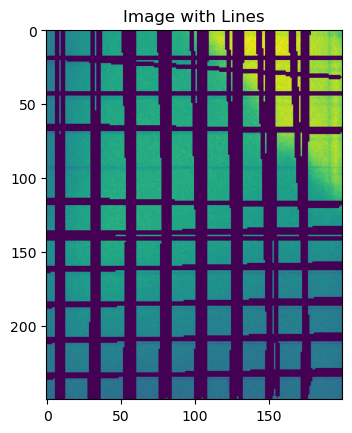

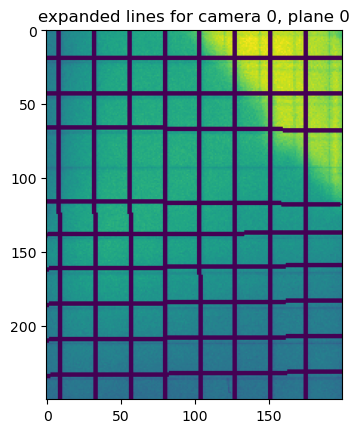

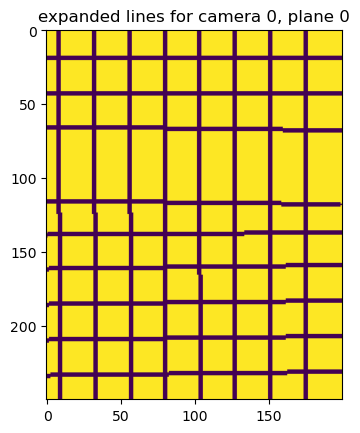

In [45]:
# use this cell to adjust settings for finding the lines in the images
# Settings used here for a test image will automatically be used for remaining images
# if this is used to adjust settings for multiple images, it becomes slightly complicated
# which settings are used for which images. This eventually needs to be fixed or documented better.


threshold_values = {

    # used in "cv2.adaptiveThreshold" to convert graph images to binary images

    # should be an odd number that approximately matches the expected spacing

    "adaptive_threshold_range": 23,

    # used in cv2.medianBlur to filter the binary image

    # larger numbers will blur out smaller features in the image other than the

    # graph lines we are trying to identify

    "blur_range": 3,

    # "edge_thresh" and "edge_aperture" are used in cv2.Canny

    # to identify edges in the images.

    # consult cv2 documentation for use

    "edge_thresh1": 100,

    "edge_thresh2": 140,

    "edge_aperture": 5,

    # line_thresh_per_pixel * #pixel used in cv2.HoughLines to

    # identify lines from edges

    "line_thresh_per_pixel": 0.55,

}


camera_number = 0

plane_number = 0

parser.find_lines(
    camera_number,
    plane_number,
    show=True,
    threshold_values=threshold_values,
    show_process=True,
)

In [50]:
parser.find_all_remaining_lines(show=False, max_display=1000)
parser.save_all_parameters()

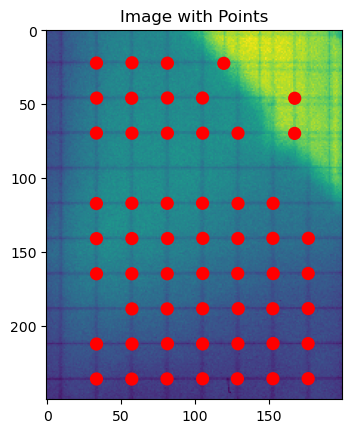

In [51]:
# for "ValueError: cannot convert float NaN to integer"
# just pick a different camera number or plane number to look at
parser.find_vertices(camera_number=0, plane_number=0, show=True)

In [48]:
# This can be uncommented to help figure out why a point was not found
# near a given location

# parser.debug_missing_point(4, 0, (80, 170))

In [52]:
parser.find_all_remaining_vertices(show=False, max_display=200)
parser.remove_nan_points()
parser.save_all_parameters()

In [ ]:
## Abhinav Coding Assignment Part 1

#Use the following dictionary to find incorrectly identified vertices: parser.calib_info_manager.all_vertices
#Ex. print(len(parser.calib_info_manager.all_vertices[0][0]))

## Function to find irregular points
#   sets: array of vertices(organized by row or column)
#   axis: check spacing along this axis
#   max_mutiple: How many avg multiples of spacing to allow in case of points being skipped
#   gap_tolerance: Tolerance for how close a gap is to a multiple
#   decimals: Rounding
# def find_irregular_points(sets, axis, spacing, max_multiple=6, gap_tolerance=0.15, decimals=4):
#     irregular_points = []

#     def to_rounded_tuple(point, decimals):
#         return tuple(np.round(point, decimals=decimals))

#     for group in sets:
#         sorted_group = group[np.argsort(group[:, axis])]
#         i = 0
#         while i < len(sorted_group) - 1:
#             gap = sorted_group[i + 1, axis] - sorted_group[i, axis]
#             ratio = gap / spacing
#             is_bad_gap = not np.any(np.isclose(ratio, np.arange(1, max_multiple + 1), atol=gap_tolerance))

#             if is_bad_gap:
#                 # Special handling for the first gap
#                 if i == 0 and len(sorted_group) > 2:
#                     next_gap = sorted_group[i + 2, axis] - sorted_group[i + 1, axis]
#                     next_ratio = next_gap / spacing
#                     if np.any(np.isclose(next_ratio, np.arange(1, max_multiple + 1), atol=gap_tolerance)):
#                         irregular_points.append(tuple(np.round(sorted_group[i], decimals=decimals)))
#                     else:
#                         irregular_points.append(tuple(np.round(sorted_group[i + 1], decimals)))
#                 else:
#                     irregular_points.append(tuple(np.round(sorted_group[i + 1], decimals)))
#                 i += 2  # Skip over next point to avoid cascading issues
#             else:
#                 i += 1

#     return irregular_points



<class 'dict'>
Sample vertices: [[np.float64(33.41958041958042), np.float64(22.067415730337075)], [np.float64(33.515957446808514), np.float64(45.79203539823009)], [np.float64(33.385474860335194), np.float64(69.4412955465587)], [np.float64(33.37012987012987), np.float64(117.10552763819095)], [np.float64(33.406976744186046), np.float64(140.84375)]]
Number of points: 55


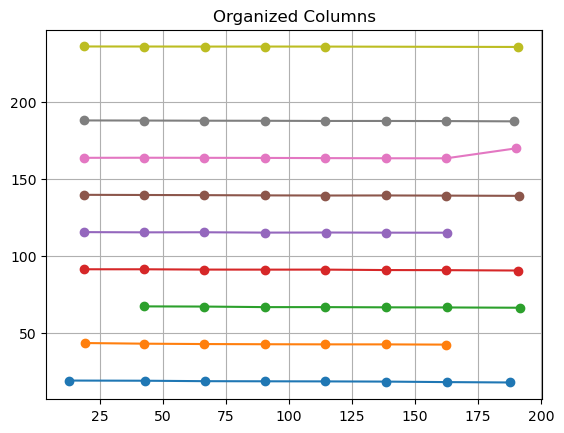

Row irregulars: 4
Row irregulars:
(np.float64(12.5793), np.float64(18.959))
(np.float64(191.625), np.float64(66.3333))
(np.float64(190.7727), np.float64(90.5412))
(np.float64(191.2143), np.float64(139.1273))

Column irregulars: 1
Column irregulars:
(np.float64(190.0), np.float64(170.0))


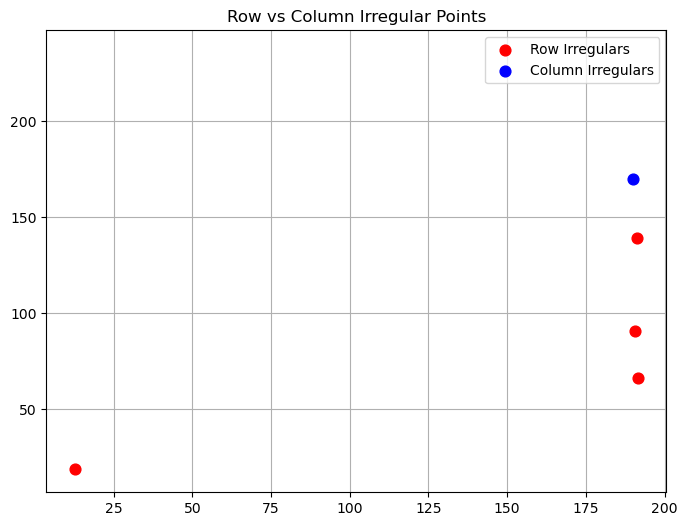

In [54]:
## Let's test this function with some arrays of vertices

# Step 1: Gather one set of vertices into an array
array1 = np.array(parser.calib_info_manager.all_vertices[0][0])
array2 = np.array(parser.calib_info_manager.all_vertices[1][1])
print(type(parser.calib_info_manager.all_vertices))
check_vert = array2

print("Sample vertices:", parser.calib_info_manager.all_vertices[0][0][:5])  # Print first 5
print("Number of points:", len(parser.calib_info_manager.all_vertices[0][0]))
# Step 2: Visualize vertices by vertical axis(axis=1 for y) to get rows 
rows = organize_by_axis(check_vert, axis=1, expected_spacing=expected_spacing)

    # Plot figure 
plt.figure()
for row in rows:
    plt.plot(row[:, 0], row[:, 1], marker='o')  
xlim = plt.xlim()
ylim = plt.ylim()
plt.title("Organized Columns")
plt.grid(True)
plt.show()

# Step 3: Get average spacing in horizontal and vertical directions using vertices and expected_spacing
h_spacing, v_spacing = get_average_spacing(check_vert,expected_spacing)
#print(h_spacing)
#print(v_spacing)


# Step 4: For each row, sort points by horizontal axis and check spacing
row_irregulars = []
col_irregulars = []

    # organize by vertical axis
rows = organize_by_axis(check_vert, axis=1, expected_spacing=v_spacing)

    # organize by horizontal axis
cols = organize_by_axis(check_vert, axis=0, expected_spacing=h_spacing)


# Step 5: Use find_irregular_points to gather arrays of 
def to_rounded_tuple(point, decimals=4):
    return tuple(np.round(point, decimals=decimals))

row_irregulars = find_irregular_points(rows, axis=0, spacing=h_spacing)
col_irregulars = find_irregular_points(cols, axis=1, spacing=v_spacing)

    # Print Lists
print("Row irregulars:", len(row_irregulars))
print("Row irregulars:")
for p in row_irregulars:
    print(p)

print("\nColumn irregulars:", len(col_irregulars))
print("Column irregulars:")
for p in col_irregulars:
    print(p)



# Step 6: Plot to check

# Convert lists of tuples back to arrays
row_arr = np.array(row_irregulars)
col_arr = np.array(col_irregulars)

plt.figure(figsize=(8, 6))

    # Plot row irregulars in red
if len(row_arr) > 0:
    plt.scatter(row_arr[:, 0], row_arr[:, 1], color='red', label='Row Irregulars', s=60)

    # Plot column irregulars in blue
if len(col_arr) > 0:
    plt.scatter(col_arr[:, 0], col_arr[:, 1], color='blue', label='Column Irregulars', s=60)


    # Apply consistent axis limits
plt.xlim(xlim)
plt.ylim(ylim)

plt.title('Row vs Column Irregular Points')
plt.legend()
plt.grid(True)
plt.show()


In [55]:
## Test code(delete)

# Initialize Irregulars Dictionary
all_irregulars = {}

# Loop through vertices dictionary(parser.calib_info_manager.all_vertices)
for plane_idx in parser.calib_info_manager.all_vertices:
    for view_idx in parser.calib_info_manager.all_vertices[plane_idx]:
        verts = np.array(parser.calib_info_manager.all_vertices[plane_idx][view_idx])


        # Compute average spacing
        h_spacing, v_spacing = get_average_spacing(verts, expected_spacing)

        # Organize rows and columns
        rows = organize_by_axis(verts, axis=1, expected_spacing=v_spacing) # Group points with similar y vals
        cols = organize_by_axis(verts, axis=0, expected_spacing=h_spacing) # Group points with similar x vals

        # Detect irregular points
        row_irregulars = find_irregular_points(rows, axis=0, spacing=h_spacing) 
        col_irregulars = find_irregular_points(cols, axis=1, spacing=v_spacing)

        # Only points that are irregular in both axes
        final_irregulars = list(set(row_irregulars) | set(col_irregulars))

        if final_irregulars:  
            all_irregulars[(plane_idx, view_idx)] = final_irregulars

# print(all_irregulars)
# print(len(all_irregulars))

TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

Step 2: Remove extraneous vertices

While this step can be improved in future versions, right now extraneous vertices must be manually removed, or they will impact the calibration results. This can be done by running ``remove_vertices.py`` (first open the file and adjust necessary settings, particularly the file names). 

Step 3: identify approximate alignment points between images

This step can likely be automated in future versions of the code, but right now the user must manually select approximate alignment points between the images. This can be done by finding a feature visible in all images, then running ``select_alignment_points.py`` to click on that point in all the images. 

Step 4: Fit calibration coefficients

In this portion, the identified graph vertices are used to perform inter- and intr-camera calibration

In [30]:
# this can be uncommented to display interactive plots
# %matplotlib notebook

In [56]:
reference_camera = 2

In [57]:
# select reference plane based on how many vertices were identified in each plane
# the first number gives the total number of vertices identified in a given plane
# between all images
# and the second number is the number of identified vertices in the image with the
# least identified vertices.
# both of these numbers should be reasonably large in the chosen reference plane
vertices = load_dictionary(calibration_filename)["all_vertices"]

for plane_num, values in vertices.items():
    plane_points = 0
    min_points = np.inf
    for cam, points in values.items():
        plane_points = plane_points + len(points)
        min_points = min(min_points, len(points))
    print(
        plane_num,
        "total points:",
        plane_points,
        ", mininum points in an image:",
        min_points,
    )

0 total points: 194 , mininum points in an image: 55
1 total points: 213 , mininum points in an image: 67
2 total points: 207 , mininum points in an image: 66
3 total points: 174 , mininum points in an image: 48
4 total points: 173 , mininum points in an image: 52


In [58]:
reference_plane = 2

In [59]:
plane_separation_mm = 0.381  # this is the step size most often used between planes
calibrator = SystemCalibrator(
    calibration_filename=calibration_filename,
    reference_plane=reference_plane,
    reference_camera=reference_camera,
    plane_separation_mm=plane_separation_mm,
    ref_plane_image_folder=None,
    useable_plane_numbers=None,  # if None, this will use all planes
)

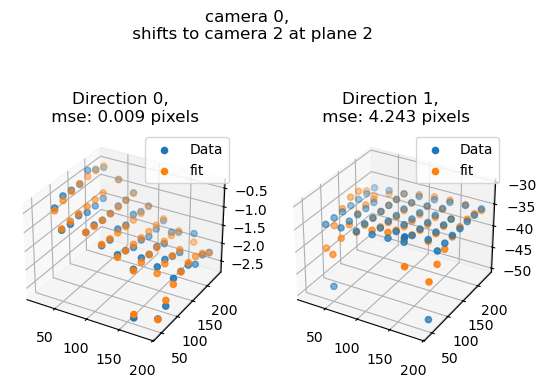

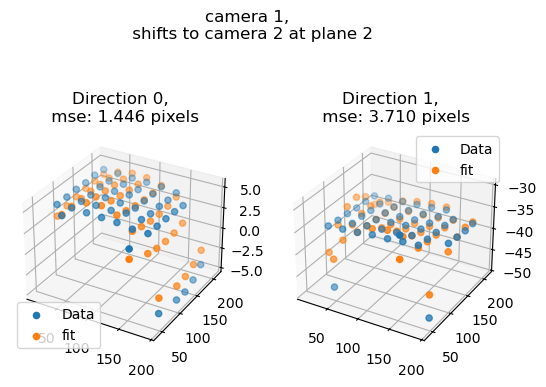

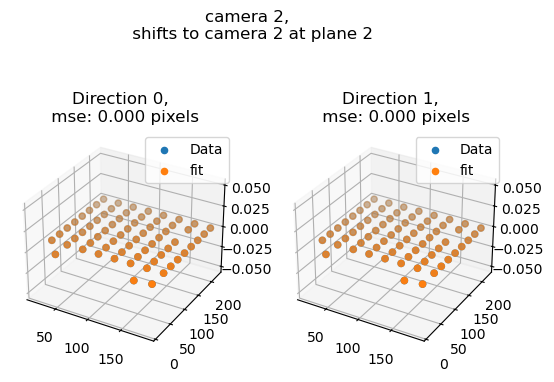

In [60]:
calibrator.run_inter_camera_calibration(show=True, order=2)

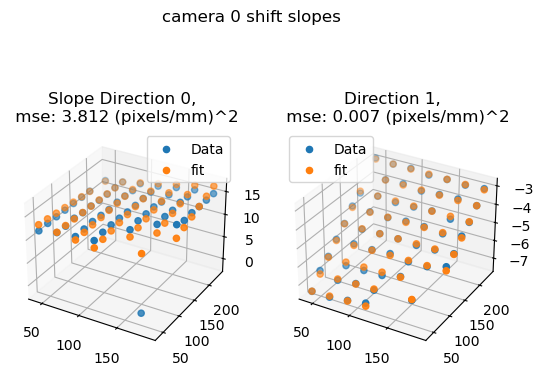

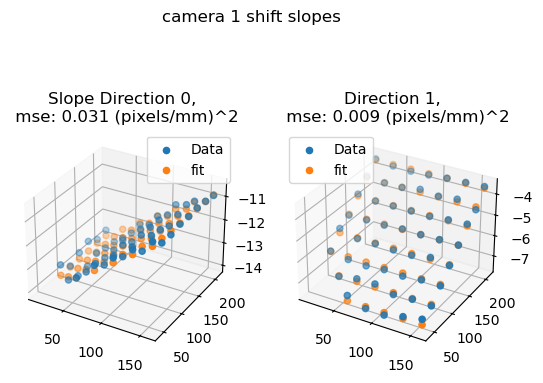

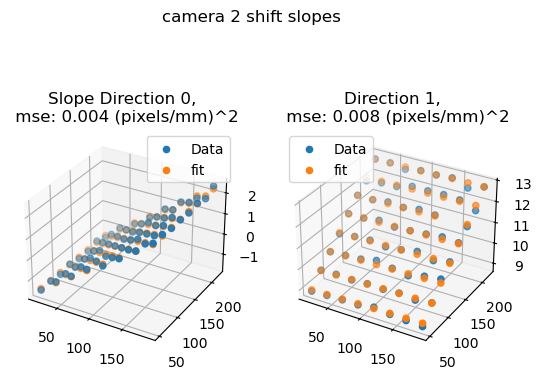

In [61]:
calibrator.run_slope_calibration(show=True, order=1)

In [ ]:
%debug



Step 5: check if results look reasonable

In [62]:
system = FLF_System(calibration_filename)
all_camera_vertices_matrices = calibrator.all_camera_vertices_matrices

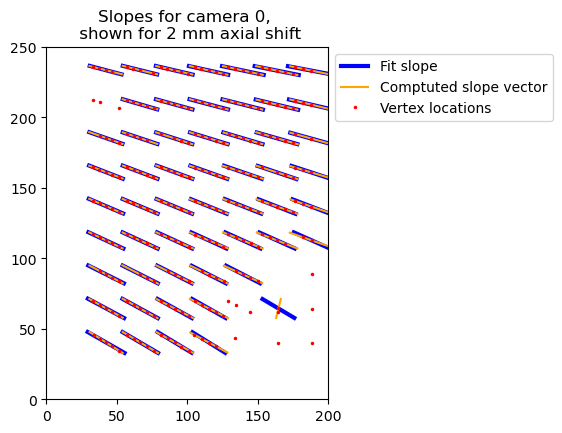

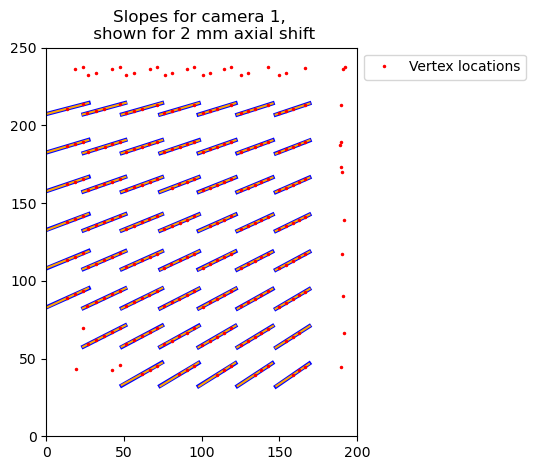

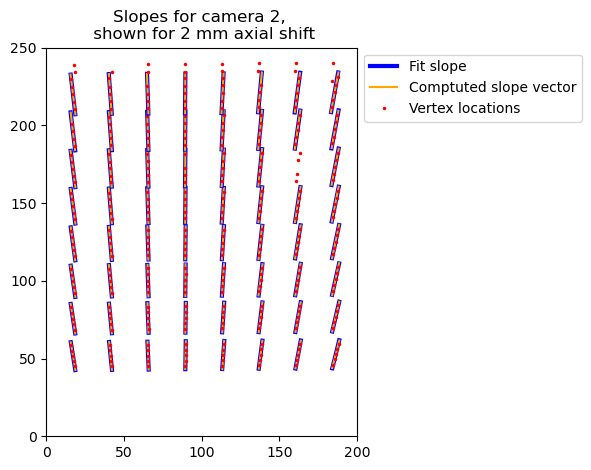

In [63]:
def make_comparison_plot(camera_number, vector_length_mm=None):
    slope0, slope1 = calibrator.get_slopes_from_vertices_matrices(camera_number)
    vertices_matrices = all_camera_vertices_matrices[camera_number]

    plt.figure()
    matrix_shape = vertices_matrices.shape[1:3]
    first = True
    for i, j in np.ndindex(matrix_shape):
        if first:
            label1 = "Comptuted slope vector"
            label2 = "Fit slope"
            label3 = "Vertex locations"
        else:
            label1 = None
            label2 = None
            label3 = None

        X = vertices_matrices[:, i, j, 0]
        Y = vertices_matrices[:, i, j, 1]

        if not np.isnan(slope0[i, j]):
            if vector_length_mm is None:
                start_plane_mm = (
                    np.where(~np.isnan(X))[0][0] - system.reference_plane
                ) * plane_separation_mm
                end_plane_mm = (
                    np.where(~np.isnan(X))[0][-1] - system.reference_plane
                ) * plane_separation_mm
            else:
                start_plane_mm = -vector_length_mm / 2
                end_plane_mm = vector_length_mm / 2

            x = vertices_matrices[system.reference_plane, i, j, 0]
            y = vertices_matrices[system.reference_plane, i, j, 1]

            # plot the slope vector that was fit to that point
            coeff0, coeff1 = system._get_slope_coeffs(camera_number)
            slope_matrix = generate_A_matrix(system.slope_order, [x], [y])
            v1 = np.matmul(slope_matrix, coeff0)[0]
            v0 = np.matmul(slope_matrix, coeff1)[0]
            x_start = x + v0 * start_plane_mm
            x_end = x + v0 * end_plane_mm
            y_start = y + v1 * start_plane_mm
            y_end = y + v1 * end_plane_mm
            plt.plot(
                [x_start, x, x_end],
                [y_start, y, y_end],
                "-",
                linewidth=3,
                color="blue",
                label=label2,
            )

            s0 = slope0[i, j]
            s1 = slope1[i, j]
            x_start = x + s0 * start_plane_mm / plane_separation_mm
            x_end = x + s0 * end_plane_mm / plane_separation_mm
            y_start = y + s1 * start_plane_mm / plane_separation_mm
            y_end = y + s1 * end_plane_mm / plane_separation_mm

            # plot the originally calculated slope vector
            plt.plot(
                [x_start, x, x_end],
                [y_start, y, y_end],
                "-",
                markersize=2,
                color="orange",
                label=label1,
            )

        if False in np.isnan(X):
            plt.plot(X, Y, ".", markersize=3, color="red", label=label3)
            first = False

    plt.legend(bbox_to_anchor=(1, 1))
    if vector_length_mm is not None:
        title = f"Slopes for camera {camera_number}, \n shown for {vector_length_mm} mm axial shift"
    else:
        title = f"Slopes for camera {camera_number}, \n vector length varies to match location of located vertices"
    plt.title(title)

    plt.xlim([0, 200])
    plt.ylim([0, 250])
    plt.tight_layout()
    plt.gca().set_aspect("equal")


for cam in system.calib_manager.image_numbers:
    make_comparison_plot(cam, vector_length_mm=2)

In [64]:
image_shape = (480, 640)

maxv = -np.inf
minv = np.inf

calib_manager = system.calib_manager

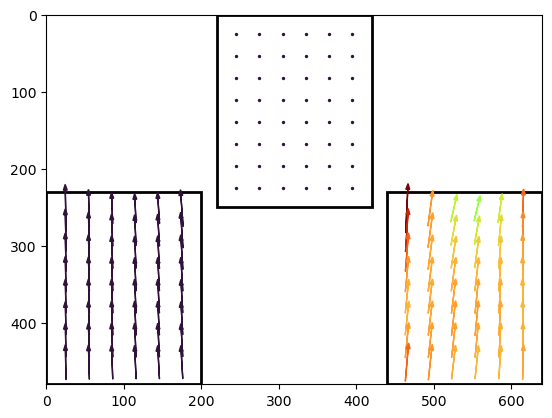

In [65]:
plt.figure()
ax = plt.gca()
ax.set_xlim(0, image_shape[1])
ax.set_ylim(0, image_shape[0])

cmap = matplotlib.cm.turbo

minv = 0

for cam_num, indices in calib_manager.crop_indices.items():
    corner = (indices[2], indices[0])
    width = indices[3] - indices[2]
    height = indices[1] - indices[0]

    rect = Rectangle(corner, width, height, fill=None, linewidth=2)
    ax.add_artist(rect)

    spacing = 25
    x_locs = np.linspace(
        spacing, height - spacing, int((height - 2 * spacing) / spacing)
    )
    y_locs = np.linspace(spacing, width - spacing, int((width - 2 * spacing) / spacing))

    # for i, j in np.ndindex((len(x_locs), len(y_locs))):
    #    x = x_locs[i]
    #    y = y_locs[j]
    y_coords, x_coords = np.meshgrid(y_locs, x_locs)
    y_coords = y_coords.flatten()
    x_coords = x_coords.flatten()
    all_v0, all_v1 = system.get_pixel_shifts(cam_num, x_coords, y_coords)

    for x, y, v0, v1 in zip(x_coords, y_coords, all_v0, all_v1):
        startx = x - v0 / 2 + indices[0]
        starty = y - v1 / 2 + indices[2]

        norm = np.sqrt(v0**2 + v1**2)
        norm = (norm - minv) / (maxv - minv)
        color = cmap(norm)
        if cam_num != calib_manager.reference_camera:
            plt.arrow(starty, startx, v1, v0, head_width=5, color=color)

    norms = np.sqrt(all_v0**2 + all_v1**2)
    maxv = max(np.max(norms), maxv)
    # minv = min(np.min(norms), minv)

    if cam_num == calib_manager.reference_camera:
        x_coords = x_coords + indices[0]
        y_coords = y_coords + indices[2]
        plt.scatter(y_coords, x_coords, color=cmap(0), s=2)
    # break


# ax.set_xticks([])
# ax.set_yticks([])

ax.invert_yaxis()

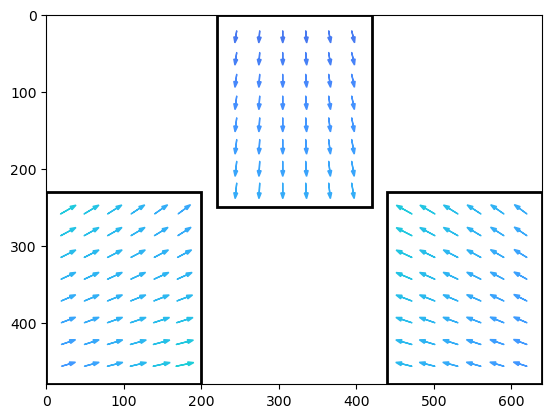

In [41]:
plt.figure()
ax = plt.gca()
ax.set_xlim(0, image_shape[1])
ax.set_ylim(0, image_shape[0])

cmap = matplotlib.cm.turbo

minv = 0

for cam_num, indices in calib_manager.crop_indices.items():
    corner = (indices[2], indices[0])
    width = indices[3] - indices[2]
    height = indices[1] - indices[0]

    rect = Rectangle(corner, width, height, fill=None, linewidth=2)
    ax.add_artist(rect)

    spacing = 25
    x_locs = np.linspace(
        spacing, height - spacing, int((height - 2 * spacing) / spacing)
    )
    y_locs = np.linspace(spacing, width - spacing, int((width - 2 * spacing) / spacing))

    # for i, j in np.ndindex((len(x_locs), len(y_locs))):
    #    x = x_locs[i]
    #    y = y_locs[j]
    y_coords, x_coords = np.meshgrid(y_locs, x_locs)
    y_coords = y_coords.flatten()
    x_coords = x_coords.flatten()
    all_v0, all_v1 = system.get_shift_slopes(cam_num, x_coords, y_coords)

    for x, y, v0, v1 in zip(x_coords, y_coords, all_v0, all_v1):
        startx = x - v0 / 2 + indices[0]
        starty = y - v1 / 2 + indices[2]

        norm = np.sqrt(v0**2 + v1**2)
        norm = (norm - minv) / (maxv - minv)
        color = cmap(norm)
        # if cam_num != calib_manager.reference_camera:
        plt.arrow(starty, startx, v1, v0, head_width=5, color=color)

    norms = np.sqrt(all_v0**2 + all_v1**2)
    maxv = max(np.max(norms), maxv)

ax.invert_yaxis()